In [26]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [27]:
df = pd.read_csv("/content/drive/MyDrive/Data Science Eugene Pinsky/Homework_10/Naive bayesian custom density/NVDA_mean_volatility_labels.csv")

In [28]:
df.head()

,Year,Week_Number,mean_return,volatility,Label
0,2017,1,0.28275,2.110070,undefined
1,2017,2,0.08460,2.299927,undefined
2,2017,3,0.15750,2.164153,undefined
3,2017,4,1.45160,0.704763,undefined
4,2017,5,0.48560,2.413944,undefined


Extracting data for both years.

In [29]:
year_1_data = df[ df["Year"] == 2020 ]
year_1_data = year_1_data.reset_index(drop=True)

year_2_data = df[ df["Year"] == 2021 ]
year_2_data = year_2_data.reset_index(drop=True)

Training on year 1

In [30]:
#getting t features for green label class
class_1 = year_1_data[ year_1_data["Label"] == "green" ]
#getting location and scale for mean_return and volatility for green label
df_return_1, location_return_1, scale_return_1 = stats.t.fit( class_1["mean_return"] )
df_vol_1, location_vol_1, scale_vol_1 = stats.t.fit( class_1["volatility"] )

#getting t features for red label class
class_2 = year_1_data[ year_1_data["Label"] == "red" ]
#getting location and scale for mean_return and volatility for red label
df_return_2, location_return_2, scale_return_2 = stats.t.fit( class_2["mean_return"] )
df_vol_2, location_vol_2, scale_vol_2 = stats.t.fit( class_2["volatility"] )

Computing prior probabilites.

In [31]:
#calculating prior probabilites for the classes in year 1
total = year_1_data.shape[0]

p_red = year_1_data["Label"].value_counts()["red"] / total
p_green = year_1_data["Label"].value_counts()["green"] / total

function to experiment with different degrees of freedom.

In [32]:
def experiment_with_df(df,X_test_return,X_test_vol):

  prob_return_green = stats.t.pdf(X_test_return,df,location_return_1, scale_return_1)
  prob_vol_green = stats.t.pdf(X_test_vol,df,location_vol_1, scale_vol_1)

  prob_return_red = stats.t.pdf(X_test_return,df,location_return_2, scale_return_2)
  prob_vol_red = stats.t.pdf(X_test_vol,df,location_vol_2, scale_vol_2)

  return prob_return_green, prob_vol_green, prob_return_red, prob_vol_red

function to label records based on the class they belong to, based on the probability computed using student t distribution used with naive bayes.

In [33]:
def label_with_prob(pred_data):

  #Creating empty column to put labels / reset labels to empty, if exists.
  pred_data["Label"] = ""

  #labelling test set according to higher probability of occurence
  for ind,row in pred_data.iterrows():

    if pred_data["prob_red"][ind] > pred_data["prob_green"][ind]:
      pred_data.loc[ind,"Label"] = "red"

    elif pred_data["prob_red"][ind] < pred_data["prob_green"][ind]:
      pred_data.loc[ind,"Label"] = "green"

  return pred_data

fucntion to compute accuracy and print accuracy for model with degrees of freedom equal to df.

In [34]:
def compute_accuracy(y_true,y_pred,df):
  
  #computing accuracy
  accuracy = accuracy_score(y_true,y_pred)

  accuracy_message = "The accuracy with degrees of freedom " + str(df) +" is : " + str(round(accuracy * 100, 2)) + " %."

  print(accuracy_message)

function to compute confusion matrix, return false positive rate and true 

In [35]:
def compute_conf_mat(y_true,y_pred,df):

  #computing confusion matrix
  conf_mat = confusion_matrix(y_true,y_pred)

  #computing true positive rate and false negative rate
  tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
  #calcultaing true positive rate
  tpr = tp/(tp+fn)
  #calcultaing true negative rate
  tnr = tn/(fp+tn)

  #displaying confusion matrix
  ConfusionMatrixDisplay.from_predictions(y_true,y_pred)

  return tpr,tnr
  

function to display true positive rate and true negative rate.

In [36]:
def print_tpr_tnr(tpr,tnr):

  #printing true positive rate and true negative rate
  tpr_message = "The true positive rate for model with degrees of freedom " + str(df) +" is : " + str(round(tpr*100,2)) +" %."
  tnr_message = "The true negative rate for model with degrees of freedom " + str(df) +" is : " + str(round(tnr*100,2)) +" %."

  print(tpr_message)
  print("\n")
  print(tnr_message)


getting test data

In [12]:
X_test_return = year_2_data["mean_return"]
X_test_vol = year_2_data["volatility"]

getting features for test set.

In [13]:
year_2_pred = year_2_data[["Year",	"Week_Number",	"mean_return",	"volatility"]]
year_2_pred.head()

,Year,Week_Number,mean_return,volatility
0,2021,1,0.41060,4.264350
1,2021,2,-0.61780,2.158119
2,2021,3,1.63475,2.093428
3,2021,4,-1.06360,1.816845
4,2021,5,0.91560,1.281591


### degrees of freedom = 0.5.

In [14]:
df = 0.5

prob_return_green, prob_vol_green, prob_return_red, prob_vol_red = experiment_with_df(df,X_test_return,X_test_vol)

#unnormalized probabilities

posterior_green = p_green * prob_return_green * prob_vol_green
posterior_red = p_red * prob_return_red * prob_vol_red

normalized_green = posterior_green / ( posterior_green + posterior_red ) 
normalized_red = posterior_red / ( posterior_green + posterior_red )

#resetting year_2_pred for new run
year_2_pred = year_2_data[["Year",	"Week_Number",	"mean_return",	"volatility"]]

#concating normalized values of probabilites for green class 
year_2_pred = pd.concat([year_2_pred,pd.DataFrame(normalized_green)],axis=1)

#concating normalized values of probabilites for red class 
year_2_pred = pd.concat([year_2_pred,pd.DataFrame(normalized_red)],axis=1)

#renaming column names
year_2_pred.columns = ["Year",	"Week_Number",	"mean_return",	"volatility","prob_green","prob_red"]

year_2_pred = label_with_prob(year_2_pred)

compute_accuracy(year_2_data["Label"],year_2_pred["Label"],df)

The accuracy with degrees of freedom 0.5 is : 69.23 %.


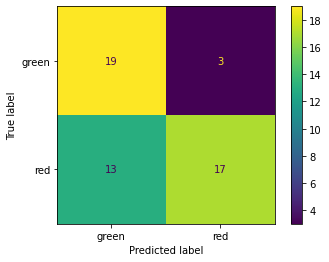

In [15]:
tpr_df_1,tnr_df_1 = compute_conf_mat(year_2_data["Label"],year_2_pred["Label"],df)

In [16]:
print_tpr_tnr(tpr_df_1,tnr_df_1)

The true positive rate for model with degrees of freedom 0.5 is : 56.67 %.


The true negative rate for model with degrees of freedom 0.5 is : 86.36 %.


###degrees of freedom 1.

In [17]:
df = 1
prob_return_green, prob_vol_green, prob_return_red, prob_vol_red = experiment_with_df(1,X_test_return,X_test_vol)

#unnormalized probabilities

posterior_green = p_green * prob_return_green * prob_vol_green
posterior_red = p_red * prob_return_red * prob_vol_red

normalized_green = posterior_green / ( posterior_green + posterior_red ) 
normalized_red = posterior_red / ( posterior_green + posterior_red )

#resetting year_2_pred for new run
year_2_pred = year_2_data[["Year",	"Week_Number",	"mean_return",	"volatility"]]

#concating normalized values of probabilites for green class 
year_2_pred = pd.concat([year_2_pred,pd.DataFrame(normalized_green)],axis=1)

#concating normalized values of probabilites for red class 
year_2_pred = pd.concat([year_2_pred,pd.DataFrame(normalized_red)],axis=1)

#renaming column names
year_2_pred.columns = ["Year",	"Week_Number",	"mean_return",	"volatility","prob_green","prob_red"]

year_2_pred = label_with_prob(year_2_pred)

compute_accuracy(year_2_data["Label"],year_2_pred["Label"],df)

The accuracy with degrees of freedom 1 is : 73.08 %.


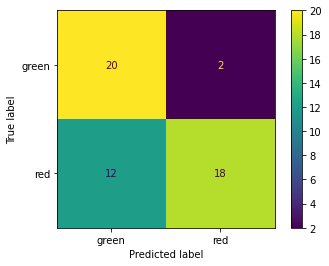

In [18]:
tpr_df_2,tnr_df_2 = compute_conf_mat(year_2_data["Label"],year_2_pred["Label"],df)

In [19]:
print_tpr_tnr(tpr_df_2,tnr_df_2)

The true positive rate for model with degrees of freedom 1 is : 60.0 %.


The true negative rate for model with degrees of freedom 1 is : 90.91 %.


###degrees of freedom 5.

In [20]:
df = 5
prob_return_green, prob_vol_green, prob_return_red, prob_vol_red = experiment_with_df(5,X_test_return,X_test_vol)

#unnormalized probabilities

posterior_green = p_green * prob_return_green * prob_vol_green
posterior_red = p_red * prob_return_red * prob_vol_red

normalized_green = posterior_green / ( posterior_green + posterior_red ) 
normalized_red = posterior_red / ( posterior_green + posterior_red )

#resetting year_2_pred for new run
year_2_pred = year_2_data[["Year",	"Week_Number",	"mean_return",	"volatility"]]

#concating normalized values of probabilites for green class 
year_2_pred = pd.concat([year_2_pred,pd.DataFrame(normalized_green)],axis=1)

#concating normalized values of probabilites for red class 
year_2_pred = pd.concat([year_2_pred,pd.DataFrame(normalized_red)],axis=1)

#renaming column names
year_2_pred.columns = ["Year",	"Week_Number",	"mean_return",	"volatility","prob_green","prob_red"]

year_2_pred = label_with_prob(year_2_pred)

compute_accuracy(year_2_data["Label"],year_2_pred["Label"],df)

The accuracy with degrees of freedom 5 is : 75.0 %.


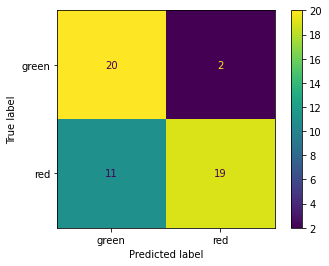

In [21]:
tpr_df_3,tnr_df_3 = compute_conf_mat(year_2_data["Label"],year_2_pred["Label"],df)

In [22]:
print_tpr_tnr(tpr_df_3,tnr_df_3)

The true positive rate for model with degrees of freedom 5 is : 63.33 %.


The true negative rate for model with degrees of freedom 5 is : 90.91 %.


### Q5.

Trading strategies

In [24]:
#function to carry out inertia trading strategy
def buy_and_hold(df,principal,end):

    #quantity of shares bought at opening price
    shares_bought = 0

    #amount gained by selling stock at closing price
    amount_gained = 0

    #value achieved from selling stocks at closing price at the end of given period.
    capital = 0 

    #buying stocks at start opening price at the start of the year.
    shares_bought = principal/df["Open"][0]

    #selling stock at its closing price
    capital = shares_bought * df["Close"][end]

    return capital

In [23]:
#function to carry out buy with label weekly trading strategy
def buy_with_labels(df,end):

  #cash amount initially used to invest in stock market
  initial_cash = 100

  #quantity of shares bought at opening price
  shares_bought = 0

  #amount gained by selling stock at adjusted closing price
  amount_gained = 0

  #value achieved from selling stocks at closing price at the end of given period.
  capital = 0 

  #boolean variable to determine if . 
  invested = False

  #iterating through dataframe
  for index,row in df.iterrows():
 
   #Finding first green week or green week after a red week ,and we dont have a position in market yet.
    if df["Label"][index] == "green" and invested ==False :
      
      #buying shares equal to the amount of cash we hold currently 
      shares_bought = initial_cash / df["Open"][index]
      
      #as we have bought shares equal in evaluation to our cash initial cash = 0
      initial_cash = 0

      #we have a position in the market
      invested = True

    #Finding red week where we dont have a position
    elif df["Label"][index] == "red" and invested ==False :
      
      #we do nothing
      continue

    #conditions if we have put money in the market

    #check to see we are not at the last day of trading.
    if index!= end:

      #if next week is red and current week is green
      if invested == True and df["Label"][index] == "green" and df["Label"][index+1] == "red":

        #selling stock at adjusted closing price at the end of the week
        initial_cash += df["Adj Close"][index] * shares_bought
        
        #all shares are sold
        shares_bought = 0
        
        #we are no longer invested in the market.
        invested = False

      #if current week is green and (next week/next day) is green 
      elif invested == True and df["Label"][index] == "green" and df["Label"][index+1] == "green":

        #do nothing
        continue

    #if we end our trading period while being invested in the market
    if index == end and invested == True:
        
        #selling stock at adjusted closing price at the end of the week
        initial_cash += df["Adj Close"][index] * shares_bought
        
        #all shares are sold
        shares_bought = 0

        #we are no longer invested in the market.
        invested = False
  
  #returning the updated cash
  return initial_cash

function to combine weekly predictions to daily data, to use for trading.

In [41]:
def label_daily_data(daily_data,weekly_data,weekly_labels):
  
  #weekly_data holds weekly data for year 2, weekly_labels holds predictions from Gaussian Naive Bayes model.
  weekly_data = pd.concat([weekly_data,pd.DataFrame(weekly_labels)],axis=1)
  
  #renaming columns so that Label column can be changed from default(0) to Label.
  weekly_data.columns = ["Year", "Week_Number",	"mean_return",	"volatility",	"Label"]

  daily_data = pd.merge(daily_data,weekly_data[["Week_Number","Label"]],on="Week_Number")

  return daily_data

In [45]:
df_daily = pd.read_csv("/content/drive/MyDrive/Data Science Eugene Pinsky/Homework_10/Naive bayesian custom density/NVDA.csv")

year_2_data_daily = df_daily[ df_daily["Year"] == 2021 ]

year_2_data_daily = year_2_data_daily.reset_index(drop=True)

year_2_data_daily.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA
0,2021-01-04 00:00:00-05:00,2021,1,4,Monday,1,2021-01,131.04,136.52,129.62,131.13,56064000,130.93,0.004481,131.436429,132.4336
1,2021-01-05 00:00:00-05:00,2021,1,5,Tuesday,1,2021-01,131.00,134.43,130.87,134.05,32276000,133.84,0.022210,131.505000,132.4432
2,2021-01-06 00:00:00-05:00,2021,1,6,Wednesday,1,2021-01,132.23,132.45,125.86,126.14,58042400,125.95,-0.058953,130.972857,132.2492
3,2021-01-07 00:00:00-05:00,2021,1,7,Thursday,1,2021-01,129.68,133.78,128.87,133.44,46148000,133.23,0.057830,131.045000,132.2904
4,2021-01-08 00:00:00-05:00,2021,1,8,Friday,1,2021-01,133.62,134.21,130.42,132.77,29252800,132.56,-0.005040,130.998571,132.2672


training with best degrees of freedom = 5, i.e the best df.

In [37]:
df = 5
prob_return_green, prob_vol_green, prob_return_red, prob_vol_red = experiment_with_df(5,X_test_return,X_test_vol)

#unnormalized probabilities

posterior_green = p_green * prob_return_green * prob_vol_green
posterior_red = p_red * prob_return_red * prob_vol_red

normalized_green = posterior_green / ( posterior_green + posterior_red ) 
normalized_red = posterior_red / ( posterior_green + posterior_red )

#resetting year_2_pred for new run
year_2_pred = year_2_data[["Year",	"Week_Number",	"mean_return",	"volatility"]]

#concating normalized values of probabilites for green class 
year_2_pred = pd.concat([year_2_pred,pd.DataFrame(normalized_green)],axis=1)

#concating normalized values of probabilites for red class 
year_2_pred = pd.concat([year_2_pred,pd.DataFrame(normalized_red)],axis=1)

#renaming column names
year_2_pred.columns = ["Year",	"Week_Number",	"mean_return",	"volatility","prob_green","prob_red"]

year_2_pred = label_with_prob(year_2_pred)

compute_accuracy(year_2_data["Label"],year_2_pred["Label"],df)

The accuracy with degrees of freedom 5 is : 75.0 %.


merging labelled weekly data with daily data.

In [46]:
year_2_data_daily = label_daily_data(year_2_data_daily,year_2_pred[["Year",	"Week_Number",	"mean_return",	"volatility"]],year_2_pred[["Label"]])
year_2_data_daily.tail()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA,Label
246,2021-12-23 00:00:00-05:00,2021,12,23,Thursday,51,2021-51,297.55,300.59,294.31,296.40,34302200,296.20,0.008163,295.482857,284.7548,green
247,2021-12-27 00:00:00-05:00,2021,12,27,Monday,52,2021-52,296.60,310.87,296.40,309.45,40368600,309.24,0.044029,296.130714,286.5938,green
248,2021-12-28 00:00:00-05:00,2021,12,28,Tuesday,52,2021-52,313.12,313.30,300.12,303.22,42059100,303.01,-0.020133,294.627857,288.2852,green
249,2021-12-29 00:00:00-05:00,2021,12,29,Wednesday,52,2021-52,302.73,305.48,293.66,300.01,34313900,299.81,-0.010586,293.325714,289.8406,green
250,2021-12-30 00:00:00-05:00,2021,12,30,Thursday,52,2021-52,298.27,304.57,295.40,295.86,30886400,295.66,-0.013833,292.680714,291.2994,green


Trading strategies results.

Buy and hold

In [47]:
capital = buy_and_hold(year_2_data_daily,100,len(year_2_data_daily)-1)
print("The capital from investing 100 dollars in buy and hold is as follows: " + str(round(capital,2)))

The capital from investing 100 dollars in buy and hold is as follows: 225.78


Buy with labels

In [48]:
#return on investment
roi = buy_with_labels(year_2_data_daily,len(year_2_data_daily)-1)
print("The cash with us after investing using buy with labels strategy is: "+str(round(roi,2)))

The cash with us after investing using buy with labels strategy is: 497.37
